In [19]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5, MAX_DETECTIONS=20):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for data in train_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()

            # Run inference (forward pass).            
            loss_E, loss_V, loss_R, VG_dist1, VG_dist2, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)            
            
            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V, VG_dist1, VG_dist2)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        #learning rate schedule
        #update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(num_actions, y, valid_dataloader)
        
        #after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            loss_E, loss_V, loss_R, VG_dist1, VG_dist2, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)


            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V, VG_dist1, VG_dist2)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device, MAX_DETECTIONS=5)

In [ ]:
train_loss, valid_loss = train(model, 8, 2, epochs=50, lr=1e-3)

Action 1: Slice the meat into chunks
-------------------------------
 the meat  -> Action 11 ([NULL]) 
 chunks  -> Action 11 ([NULL]) 


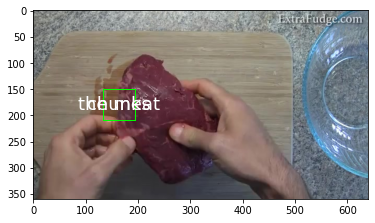

Action 2: mix paprika and pepper with the meat
-------------------------------
 paprika  -> Action 1 (Slice the meat into chunks) 
 pepper  -> Action 1 (Slice the meat into chunks) 
 the meat  -> Action 1 (Slice the meat into chunks) 


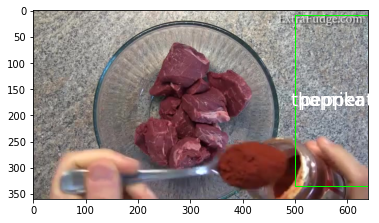

Action 3: cut the onion into slices
-------------------------------
 the onion  -> Action 1 (Slice the meat into chunks) 
 slices  -> Action 11 ([NULL]) 


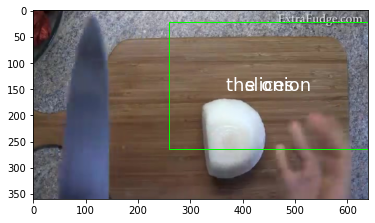

Action 4: Add oil to a pot
-------------------------------
 oil  -> Action 1 (Slice the meat into chunks) 
 a pot  -> Action 1 (Slice the meat into chunks) 


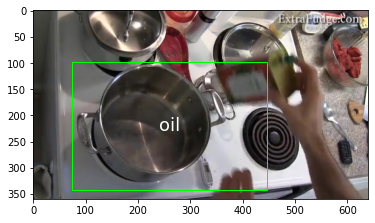

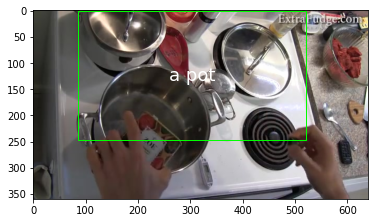

Action 5: Cook the onions in the pot
-------------------------------
 the onions  -> Action 4 (Add oil to a pot) 
 the pot  -> Action 4 (Add oil to a pot) 


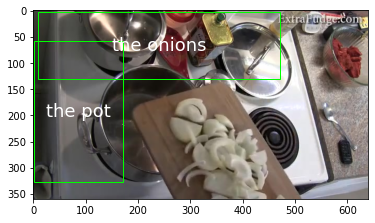

Action 6: Cook the meat in the pot
-------------------------------
 the meat  -> Action 5 (Cook the onions in the pot) 
 the pot  -> Action 5 (Cook the onions in the pot) 


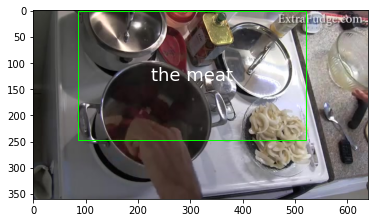

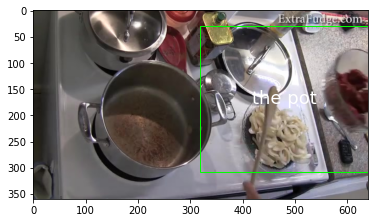

Action 7: Add water to the pot
-------------------------------
 water  -> Action 4 (Add oil to a pot) 
 the pot  -> Action 5 (Cook the onions in the pot) 


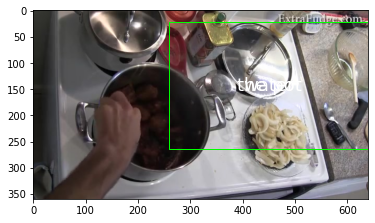

Action 8: Add tomato
-------------------------------
 tomato  -> Action 5 (Cook the onions in the pot) 


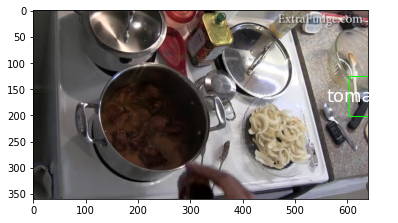

Action 9: Add onions
-------------------------------
 onions  -> Action 4 (Add oil to a pot) 


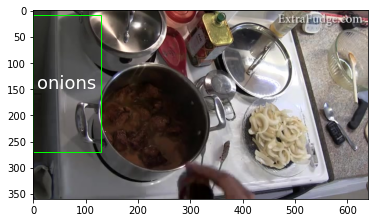

In [21]:
from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 10, 1, FI)

In [22]:
# Saving and loading weights.

SAVE = False
LOAD = False

if SAVE:
    torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/weights-epochs=50,bs=2,lr=1e-3,a=8")
    
if LOAD:
    model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/weights-epochs=50,bs=2,lr=1e-3,a=8"))

In [ ]:
# Reload modules.

import importlib
import visualizer

importlib.reload(visualizer)